# LIT-PCBA 
this dataset is a proposed "more difficult" test than DUD-E. I used a 75/25 (sklearn default) stratified split. The dataset is heavily imbalanced, like DUD-E.

In [1]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)

In [2]:
def compute_enrichment_factor(scores, labels, n_percent):
    # this variant implements the equation from Xiaohua's paper

    sample_n = int(np.ceil(n_percent * labels.shape[0]))
    
    
    
    sorted_scores = sorted(zip(scores, labels), key=lambda x: x[0], reverse=True)

    top_n_sorted_scores = sorted_scores[:sample_n]

    # counting number of true positives in top x% of sorted compounds
    actives_sampled = sum([y for x, y in top_n_sorted_scores])
    # labels are binary, sum to count number of actives
    actives_database = sum(labels)

    norm_factor = (sample_n/len(labels))

    return (actives_sampled / actives_database) * (labels.shape[0]/sample_n)


In [3]:
# data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/0")
data_p = Path("/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results")

In [4]:
lit_pcba_path_list = [x for x in list(data_p.glob("lit_pcba.*.pkl")) if "lit_pcba_ave" not in x.parent.parent.name]
lit_pcba_path_list 

[PosixPath('/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.ADRB2.ecfp.atomwise.0.pkl'),
 PosixPath('/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.ADRB2.mlp.atomwise.0.pkl'),
 PosixPath('/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.ADRB2.rf.atomwise.0.pkl'),
 PosixPath('/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.ADRB2.rp.atomwise.0.pkl'),
 PosixPath('/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.ADRB2.selfies.None.0.pkl'),
 PosixPath('/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.ADRB2.selfies.selfies-charwise.0.pkl'),
 PosixPath('/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.ADRB2.smiles-pe.atomwise.0.pkl'),
 PosixPath('/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results

In [5]:
# import re

lit_pcba_target_names = list(set([x.name.split('.')[1] for x in lit_pcba_path_list]))
lit_pcba_target_names

['PPARG',
 'TP53',
 'MTORC1',
 'OPRK1',
 'ESR1_ago',
 'MAPK1',
 'ESR1_ant',
 'GBA',
 'ALDH1',
 'IDH1',
 'PKM2',
 'KAT2A',
 'ADRB2',
 'FEN1',
 'VDR']

In [6]:
def load_pkl(pkl_path, model, return_sizes=False):
    
    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
        
        if 0 in data.keys():
            data = data[0]

        
        if "encode_time" not in data.keys():
            return
    
    if isinstance(data["y_true"], np.ndarray):
        y_true = data["y_true"]
    else:
        y_true = np.concatenate(data["y_true"]) 
    y_pred = np.array(data["y_pred"])

    
    eta = np.array(data["eta"])

    if np.unique(y_true).shape[0] < 2 :
        metric = 0
    else:
        metric = recall_score(y_pred=y_pred, y_true=y_true)
        if model in ["rf", "mlp"]:
            eta= eta[:, 1]

    print(pkl_path)
    if return_sizes:
        return y_true, y_pred, eta, metric, data["encode_time"], data["train_time"], data["test_time"], data["train_size"], data["test_size"]
    else:
        return y_true, y_pred, eta, metric, data["encode_time"], data["train_time"], data["test_time"]


# LIT-PCBA Results

In [7]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("Reds", 10)

In [19]:
color_dict = {
    "smiles-pe.atomwise.0": rocket_color_pal[2],
    "smiles-pe.bpe.0": rocket_color_pal[4],   
#     "smiles-pe.ngram.1": color_pal[0],
#     "selfies.None": "purple",
"selfies.None": green_color_pal[4],
#     "selfies.selfies-charwise": color_pal[2],
    "ecfp": green_color_pal[6],
    "rp": green_color_pal[8],
    "rf": blue_color_pal[4],
#     "openhd": "green",
    "mlp": blue_color_pal[7],
#     "Vina": color_pal[2]
}

marker_dict = {
#     "smiles-pe": "+",
    "smiles-pe.atomwise.0": "+",
    "smiles-pe.bpe.0": "+",   
#     "smiles-pe.ngram.1": "+",
    "selfies.None": "*",
#     "selfies.selfies-charwise": "*",
    "ecfp": "+",
    "rp": "+",
    "rf": "^",
#     "openhd": "*",
    "mlp": "+",
#     "Vina": "+"
}


model_order_list = [
    ("smiles-pe.atomwise.0", "MoleHD-Atomw."),
    ("smiles-pe.bpe.0", "MoleHD-BPE"),
#     ("smiles-pe.ngram.1", "SMILES uni-gram"),
    ("selfies.None", "HDBind-SELFIES"),
#     ("selfies.selfies-charwise", "SELFIES uni-gram"),
    ("ecfp", "HDBind-ECFP"),
    ("rp", "HDBind-ECFP+RP"),
    ("rf", "RF"),
    ("mlp", "MLP"),
#     ("Vina", "Vina")
]


model_name_dict = {
    "smiles-pe.atomwise.0": "MoleHD-Atomw.", 
    "smiles-pe.bpe.0": "MoleHD-BPE",
#     "smiles-pe.ngram.1": "SMILES uni-gram",
    "selfies.None": "HDBind-SELFIES",
#     "selfies.selfies-charwise": "SELFIES uni-gram",
    "ecfp": "HDBind-ECFP",
    "rp": "HDBind-ECFP+RP",
    "rf": "RF",
    "mlp": "MLP",
    "Vina": "Vina"
}


linestyle_dict = {
    "smiles-pe.atomwise.0": "-", 
    "smiles-pe.bpe.0": ":",
    "selfies.None": "-",
    "ecfp": ":",
    "rp": "-.",
    "rf": "-",
    "mlp": ":",
    "Vina": "-"
}

In [8]:



def aggregate_lit_pcba_results(dataset):
    
    model_metric_dict = {}

    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]

    
    f, ax = plt.subplots(1,2, figsize=(16,6))
    ax = ax.flatten()

    for model, color in color_dict.items():
        
        marker = marker_dict[model]
        
        model_metric_dict[model] = []
        
        metric_list = []
        encode_time_list = []
        train_time_list = []
        test_time_list = []
        eta_list = []
        

        data_path_list = list(data_p.glob(f"{dataset}*.{model}*pkl"))
        
        train_size_list = []
        test_size_list = []
        target_size_list = []
        
        
        enrich_1_list = []
        enrich_10_list = []
        
        for path in data_path_list:
            
            target = path.stem.split(".")[1]
            print(target)
            
            y_true, y_pred, eta, m, encode_time, train_time, test_time, train_size, test_size = load_pkl(path, model=model, return_sizes=True)
            
            if m is None:
                pass
            else:
                metric_list.append(m)
                encode_time_list.append(encode_time)
                train_time_list.append(train_time/10) # because i retrained 10 times
                test_time_list.append(test_time)
                eta_list.append(eta)
                train_size_list.append(train_size)
                test_size_list.append(test_size)
                
                enrich_1 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.01)
                enrich_1_list.append(enrich_1)
                
                enrich_10 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.1)
                enrich_10_list.append(enrich_10)

                target_size_list.append(train_size+test_size)
                
                model_metric_dict[model].append((m, enrich_1, enrich_10))
                
        
                

    return enrich_f, enrich_1_ax, enrich_10_ax, model_metric_dict




ADRB2
/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.ADRB2.smiles-pe.atomwise.0.pkl
ALDH1
/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.ALDH1.smiles-pe.atomwise.0.pkl
ESR1_ago
/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.ESR1_ago.smiles-pe.atomwise.0.pkl
ESR1_ant
/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.ESR1_ant.smiles-pe.atomwise.0.pkl
FEN1
/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.FEN1.smiles-pe.atomwise.0.pkl
GBA
/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.GBA.smiles-pe.atomwise.0.pkl
IDH1
/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.IDH1.smiles-pe.atomwise.0.pkl
KAT2A
/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.KAT2A.smile

KAT2A
/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.KAT2A.rp.atomwise.0.pkl
MAPK1
/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.MAPK1.rp.atomwise.0.pkl
MTORC1
/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.MTORC1.rp.atomwise.0.pkl
OPRK1
/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.OPRK1.rp.atomwise.0.pkl
PKM2
/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.PKM2.rp.atomwise.0.pkl
PPARG
/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.PPARG.rp.atomwise.0.pkl
TP53
/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.TP53.rp.atomwise.0.pkl
VDR
/usr/WS1/jones289/hd-cuda-master/hdpy/hdpy/before_rng_results/before_rng_results/lit_pcba.VDR.rp.atomwise.0.pkl
ADRB2
/usr/WS1/jones289/hd-cuda-master/hdpy/hd

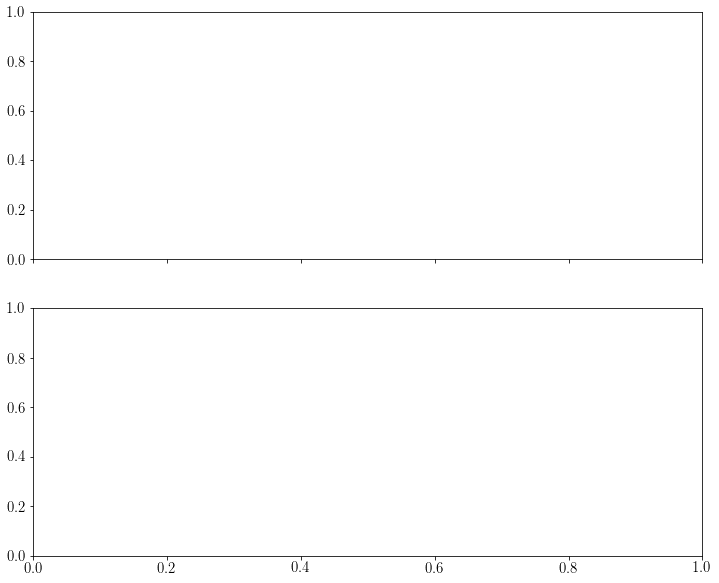

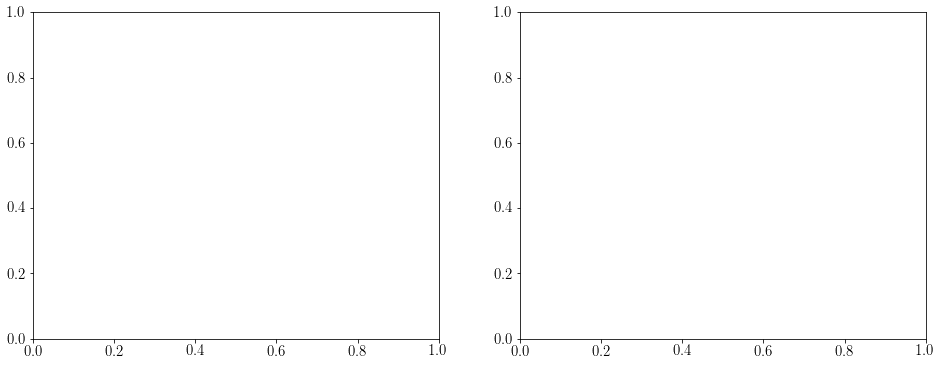

In [9]:
lit_pcba_enrich_f, lit_pcba_enrich_1_ax, lit_pcba_enrich_10_ax, model_metric_dict = aggregate_lit_pcba_results(dataset="lit_pcba")


In [10]:
print([len(x) for x in model_metric_dict.values()])
print([x for x in model_metric_dict.keys()])

[15, 15, 15, 15, 15, 15, 15]
['smiles-pe.atomwise.0', 'smiles-pe.bpe.0', 'selfies.None', 'ecfp', 'rp', 'rf', 'mlp']


In [11]:
# 'smiles-pe.ngram.2', 'smiles-pe.ngram.3', 'rf', 'mlp'

In [12]:
# import pdb 
# pdb.set_trace()

model_metric_df = pd.DataFrame(model_metric_dict)
model_metric_df_list = [pd.DataFrame({"metric": [tup[0] for tup in model_metric_df[col].values], 
                                      "enrich-1": [tup[1] for tup in model_metric_df[col].values],
                                      "enrich-10": [tup[2] for tup in model_metric_df[col].values],
                                      "model": [col]*len(model_metric_df)}) for col in model_metric_df.columns]

model_metric_df = pd.concat(model_metric_df_list)
model_metric_df

,metric,enrich-1,enrich-10,model
0,0.000000,0.000000,0.000000,smiles-pe.atomwise.0
1,0.000000,1.338695,1.037775,smiles-pe.atomwise.0
2,0.000000,0.000000,0.000000,smiles-pe.atomwise.0
3,0.038462,3.736686,1.529982,smiles-pe.atomwise.0
4,0.000000,0.000000,0.869497,smiles-pe.atomwise.0
...,...,...,...,...
10,0.000000,66.627160,10.000000,mlp
11,0.043796,29.887169,5.255304,mlp
12,0.000000,26.734694,4.285714,mlp
13,0.300000,28.963636,4.466355,mlp


In [13]:
model_metric_df['enrich-1'] = model_metric_df['enrich-1'].apply(lambda x: float(np.array(x)))
model_metric_df['enrich-10'] = model_metric_df['enrich-10'].apply(lambda x: float(np.array(x)))

In [14]:
# sns.boxplot(data=model_metric_df, x="model", y="metric", ax=lit_pcba_ax[0], palette=color_dict)
# lit_pcba_f

In [15]:
sns.boxplot(data=model_metric_df, x="model", y="enrich-1", ax=lit_pcba_enrich_1_ax, palette=color_dict)
lit_pcba_enrich_1_ax.set_title("(a) LIT-PCBA Enrichment at 1\%", fontdict={"fontsize": 18})
lit_pcba_enrich_1_ax.set_xlabel("")
lit_pcba_enrich_1_ax.set_ylabel("")
lit_pcba_enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

# lit_pcba_enrich_1_ax.set_xticklabels(labels)
# labels = [x[1] for x in model_order_list]
labels = [model_name_dict[x.get_text()] for x in lit_pcba_enrich_1_ax.get_xticklabels()]
lit_pcba_enrich_1_ax.set_xticklabels(labels)
plt.tight_layout()




plt.tight_layout()
# lit_pcba_enrich_1_f.savefig("lit_pcba_enrich_1.png", dpi=600, bbox_inches="tight")
# lit_pcba_enrich_1_f

<Figure size 432x288 with 0 Axes>

In [16]:
sns.boxplot(data=model_metric_df, x="model", y="enrich-10", ax=lit_pcba_enrich_10_ax, palette=color_dict)
lit_pcba_enrich_10_ax.set_title("(b) LIT-PCBA Enrichment at 10\%", fontdict={"fontsize": 18})
lit_pcba_enrich_10_ax.set_xlabel("")
lit_pcba_enrich_10_ax.set_ylabel("")
lit_pcba_enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
# labels = [item.get_text() for item in lit_pcba_enrich_10_ax.get_xticklabels()]
labels = [model_name_dict[x.get_text()] for x in lit_pcba_enrich_10_ax.get_xticklabels()]
lit_pcba_enrich_10_ax.set_xticklabels(labels)
plt.tight_layout()
# lit_pcba_enrich_10_f.savefig("lit_pcba_enrich_10.png", dpi=600, bbox_inches="tight")
# lit_pcba_enrich_10_f

<Figure size 432x288 with 0 Axes>

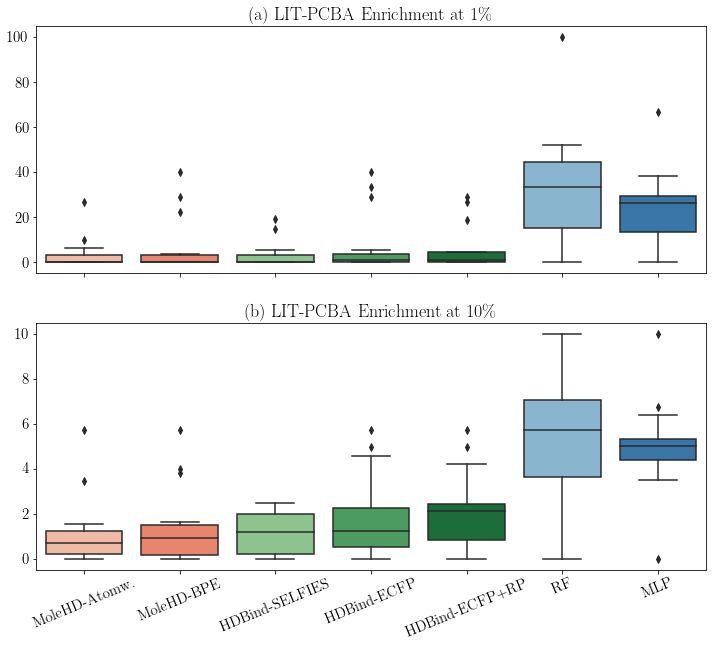

In [17]:
lit_pcba_enrich_f.savefig("lit_pcba_enrich.png", dpi=600, bbox_inches="tight")

lit_pcba_enrich_f


In [18]:
model_metric_df[['enrich-1', 'enrich-10', 'model']].groupby("model").describe()

enrich-1                                        \
                        count       mean        std  min        25%   
model                                                                 
ecfp                     15.0   7.649219  13.990717  0.0   0.000000   
mlp                      15.0  23.873425  16.676006  0.0  13.266607   
rf                       15.0  32.288861  26.228586  0.0  15.206644   
rp                       15.0   5.891674  10.107685  0.0   0.000000   
selfies.None             15.0   3.171019   5.964401  0.0   0.000000   
smiles-pe.atomwise.0     15.0   3.401933   7.048207  0.0   0.000000   
smiles-pe.bpe.0          15.0   6.807744  12.771598  0.0   0.000000   

                                                      enrich-10            \
                            50%        75%        max     count      mean   
model                                                                       
ecfp                   0.728955   3.763651  40.102041      15.0  1.812024   
mlp                   26.156805  29.425403  66.627160      15.0  4.962906   
rf                    33.630178  44.328039  99.940741      15.0  5.270183   
rp                     0.904652   4.334350  28.963636      15.0  2.136247   
selfies.None           0.000000   3.126749  19.309091      15.0  1.171142   
smiles-pe.atomwise.0   0.000000   3.225322  26.734694      15.0  1.167224   
smiles-pe.bpe.0        0.000000   2.994617  40.102041      15.0  1.391411   

                                                                              
                           std  min       25%       50%       75%        max  
model                                                                         
ecfp                  1.857310  0.0  0.502394  1.224434  2.258074   5.714286  
mlp                   2.062881  0.0  4.376035  4.998791  5.305120  10.000000  
rf                    2.706669  0.0  3.612909  5.713900  7.045260  10.000000  
rp                    1.711636  0.0  0.828412  2.126649  2.445478   5.714286  
selfies.None          0.939366  0.0  0.208283  1.190396  1.974315   2.481308  
smiles-pe.atomwise.0  1.534987  0.0  0.208283  0.714237  1.223063   5.714286  
smiles-pe.bpe.0       1.737966  0.0  0.145981  0.908802  1.481850   5.714286